In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

In [2]:
!pip install -U scikit-survival

     |████████████████████████████████| 2.5 MB 16.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.17.0-cp37-cp37m-linux_x86_64.whl size=4088299 sha256=5633875aea5c97e6e01cc994e0c23edd9cc167a418adb2ae8f0fdc8ec4e017aa
  Stored in directory: /root/.cache/pip/wheels/91/c1/99/2c2faacc82ff4f89d27612b1fd905ea35aa24f6a93dd4dcc0d
Successfully built scikit-survival


In [3]:
from sksurv.ensemble import RandomSurvivalForest

In [4]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

Saving 0227_X_y_imputed_whole.csv to 0227_X_y_imputed_whole.csv


In [5]:
import io
feature_and_target = pd.read_csv(io.BytesIO(uploaded['0227_X_y_imputed_whole.csv'])) 

In [6]:
feature_and_target.drop('Unnamed: 0', axis = 1, inplace = True)
feature_and_target

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,...,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,348.0,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,70.157760,53.040000,120.033333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000,13.18,0
1,533.0,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,79.560000,51.000000,...,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000,9.44,1
2,902.0,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,58.204386,62.220000,...,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319,5.06,0
3,1736.0,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,71.000000,58.400000,121.400000,...,-0.632911,0.000000,0.632911,0.000000,0.000000,-0.632911,-1.898734,0.632911,8.02,1
4,3971.0,8.0,0.0,-12.427397,-25.084932,0.0,12.657534,86.000000,53.040000,88.900000,...,-0.080400,-0.133462,-0.067174,-0.043216,-0.019409,-0.095040,-0.630737,-0.129774,12.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,998542.0,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,53.040000,72.400000,...,-0.080372,-0.133328,-0.067473,-0.042912,-0.019622,-0.095156,-0.630606,-0.129981,0.26,0
2823,998756.0,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,88.400000,70.200000,...,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519,2.10,0
2824,999166.0,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,83.980000,84.750000,...,-0.080250,-0.133307,-0.067436,-0.043003,-0.019727,-0.094630,-0.630937,-0.130134,12.82,0
2825,999823.0,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,100.800000,74.400987,70.460000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.743494,0.000000,0.000000,6.05,0


In [7]:
# Check the proportion of censored data
event_distribution = pd.DataFrame(feature_and_target[['status_opt']].value_counts()).reset_index()
event_distribution.columns = ['status', 'count']
event_distribution['status'] = event_distribution['status'].astype('bool')
event_distribution = event_distribution.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)   # 2198 censored, 629 uncensored  (78% censored)

         status  count
0  0 (censored)   2198
1   1 (occured)    629


In [8]:
df_for_featsel = feature_and_target.copy()
df_for_featsel.drop('SubjectID', axis = 1, inplace = True)

In [9]:
df_for_featsel.columns

Index(['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_fvc', 'mean_Creatinine', 'mean_weight',
       'slope_weight', 'mean_ALSFRS_R_Total', 'mean_Q1_Speech',
       'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting',
       'mean_Q5_Cutting', 'mean_Q6_Dressing_and_Hygiene',
       'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs',
       'mean_R1_Dyspnea', 'mean_R2_Orthopnea',
       'mean_R3_Respiratory_Insufficiency', 'mean_bulbar', 'mean_motor',
       'mean_respiratory', 'slope_ALSFRS_R_Total', 'slope_Q1_Speech',
       'slope_Q2_Salivation', 'slope_Q3_Swallowing', 'slope_Q4_Handwriting',
       'slope_Q5_Cutting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs', 'slope_R1_Dyspnea', 'slope_R2_Orthopnea',
       'slope_R3_Respiratory_Insufficiency', 'slope_bulbar', 'slope_motor',
       'slope_respiratory', 'time_opt', 'status_opt

In [10]:
# Use only total score & 3 dimension score for ALSFRS (exclude individual Q1 - Q12 score)
df_for_featsel = df_for_featsel[['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_fvc', 'mean_Creatinine', 'mean_weight',
       'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'mean_motor',
       'mean_respiratory', 'slope_ALSFRS_R_Total', 'slope_bulbar', 'slope_motor',
       'slope_respiratory', 'time_opt', 'status_opt']]
df_for_featsel

,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,70.157760,53.040000,120.033333,1.840796,38.250000,8.000000,14.250000,12.000000,-0.497512,0.000000,-0.497512,0.000000,13.18,0
1,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,79.560000,51.000000,-0.167224,36.666667,3.000000,21.333333,11.000000,-0.334448,-0.334448,0.334448,0.000000,9.44,1
2,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,58.204386,62.220000,-0.602007,40.250000,7.250000,18.250000,11.000000,-1.086957,0.362319,-1.086957,-0.362319,5.06,0
3,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,71.000000,58.400000,121.400000,-1.280075,24.500000,5.500000,4.500000,11.500000,-3.164557,-0.632911,-1.898734,0.632911,8.02,1
4,8.0,0.0,-12.427397,-25.084932,0.0,12.657534,86.000000,53.040000,88.900000,-1.250000,38.000000,8.000000,14.000000,12.000000,-0.896762,-0.095040,-0.630737,-0.129774,12.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,53.040000,72.400000,0.869153,35.500000,8.000000,14.000000,10.500000,-0.896782,-0.095156,-0.630606,-0.129981,0.26,0
2823,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,88.400000,70.200000,-3.461413,34.000000,5.666667,19.000000,6.666667,0.534759,0.000000,0.000000,1.069519,2.10,0
2824,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,83.980000,84.750000,0.871275,43.000000,7.000000,21.000000,12.000000,-0.897026,-0.094630,-0.630937,-0.130134,12.82,0
2825,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,100.800000,74.400987,70.460000,-0.535117,43.250000,5.500000,22.750000,12.000000,-0.743494,-0.743494,0.000000,0.000000,6.05,0


# 1. Wrapper method

In [ ]:
pip install lifelines

##1-1. AFT

### (1) GridSearchcv with lasso

In [ ]:
from sklearn.model_selection import GridSearchCV

aft_params ={ 'penalizer': [1e-2, 0.05, 0.1, 0.5, 1],
              'l1_ratio' : [1]  }

In [ ]:
# 3분 소요
from lifelines import WeibullAFTFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_aft = df_for_featsel.drop(columns = 'time_opt')
y_aft = df_for_featsel['time_opt']

base_class2 = sklearn_adapter(WeibullAFTFitter, event_col = 'status_opt')
aft = base_class2()

grid_cv2 = GridSearchCV(aft, param_grid = aft_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv2.fit(X_aft, y_aft)

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisabl

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnWeibullAFTFitter(alpha=0.05, fit_intercept=True,
                                               l1_ratio=0.0,
                                               model_ancillary=False,
                                               penalizer=0.0),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.01, 0.05, 0.1, 0.5, 1]})

In [ ]:
# Result : hyperparameter selected
print(grid_cv2.best_score_)  # 0.860420864370606
print(grid_cv2.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01}

0.860420864370606
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel, duration_col='time_opt', event_col='status_opt', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.WeibullAFTFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
   number of observations = 2827
number of events observed = 629
           log-likelihood = -2512.71
         time fit was run = 2022-03-04 01:22:27 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                    
lambda_ Age                   -0.06       0.94       0.01            -0.07            -0.04                 0.93                 0.96
        Gender                 0.00       1.00       0.05            -0.09             0.09                 0.91                 1.10
        diag_delta            -0.01       0.99        NaN              NaN              NaN                  NaN                  NaN
        diag_minus_onset      -0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_ALSFRS_R_Total    0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
        mean_Creatinine        0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
        mean_bulbar            0.26       1.30       0.04             0.18             0.34                 1.20                 1.41
        mean_fvc               0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
        mean_motor             0.00       1.00       0.03            -0.06             0.06                 0.95                 1.06
        mean_respiratory      -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
        mean_weight            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        onset_delta           -0.01       0.99        NaN              NaN              NaN                  NaN                  NaN
        onset_site            -0.09       0.91       0.06            -0.21             0.03                 0.81                 1.03
        slope_ALSFRS_R_Total   0.07       1.07       0.05            -0.03             0.17                 0.97                 1.19
        slope_bulbar           0.22       1.24       0.07             0.07             0.36                 1.07                 1.44
        slope_motor            0.00       1.00       0.06            -0.11             0.11                 0.90                 1.12
        slope_respiratory     -0.03       0.97       0.07            -0.15             0.10                 0.86                 1.11
        slope_weight           0.06       1.06       0.01             0.04             0.08                 1.04                 1.09
        Intercept              0.88       2.41       0.23             0.44             1.32                 1.55                 3.75
rho_    Intercept              0.73       2.07       0.03             0.67             0.78                 1.96                 2.19

                                 z      p   -log2(p)
param   covariate                                   
lambda_ Age                  -6.87 <0.005      37.20
        Gender                0.00   1.00       0.00
        diag_delta             NaN    NaN        NaN
        diag_minus_onset       NaN    NaN        NaN
        mean_ALSFRS_R_Total   0.32   0.75       0.42
        mean_Creatinine       2.10   0.04       4.81
        mean_bulbar           6.56 <0.005      34.10
        mean_fvc              3.87 <0.005      13.17
        mean_motor            0.00   1.00       0.00
        mean_respiratory     -0.22   0.82       0.28
        mean_weight           1.62   0.11  

In [ ]:
# insignificant features excluded (coefficient < 0.01 )
aft_final_feature_list = ['Age',  'diag_delta', 'onset_delta', 'onset_site',
        'mean_fvc', 
       'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 
       'mean_respiratory', 'slope_ALSFRS_R_Total', 'slope_bulbar',
       'slope_respiratory'] # 12 features

In [ ]:
# Refit with final selected feature
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel[aft_final_feature_list+['time_opt', 'status_opt']], duration_col='time_opt', event_col='status_opt', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

<lifelines.WeibullAFTFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
   number of observations = 2827
number of events observed = 629
           log-likelihood = -2517.63
         time fit was run = 2022-03-04 01:37:43 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                    
lambda_ Age                   -0.06       0.94       0.01            -0.08            -0.04                 0.92                 0.96
        diag_delta            -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
        mean_ALSFRS_R_Total    0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
        mean_bulbar            0.26       1.30       0.02             0.23             0.30                 1.25                 1.35
        mean_fvc               0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
        mean_respiratory      -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
        onset_delta           -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
        onset_site            -0.10       0.91       0.06            -0.22             0.02                 0.81                 1.02
        slope_ALSFRS_R_Total   0.07       1.07       0.02             0.04             0.11                 1.04                 1.11
        slope_bulbar           0.22       1.25       0.05             0.12             0.32                 1.13                 1.37
        slope_respiratory     -0.02       0.98       0.04            -0.10             0.06                 0.91                 1.06
        slope_weight           0.06       1.07       0.01             0.04             0.08                 1.04                 1.09
        Intercept              1.23       3.43       0.21             0.81             1.65                 2.26                 5.21
rho_    Intercept              0.72       2.05       0.03             0.66             0.77                 1.94                 2.17

                                 z      p   -log2(p)
param   covariate                                   
lambda_ Age                  -6.81 <0.005      36.54
        diag_delta           -1.91   0.06       4.15
        mean_ALSFRS_R_Total   2.34   0.02       5.70
        mean_bulbar          13.84 <0.005     142.29
        mean_fvc              4.04 <0.005      14.20
        mean_respiratory     -0.69   0.49       1.03
        onset_delta          -3.96 <0.005      13.73
        onset_site           -1.59   0.11       3.15
        slope_ALSFRS_R_Total  4.19 <0.005      15.12
        slope_bulbar          4.49 <0.005      17.10
        slope_respiratory    -0.48   0.63       0.67
        slope_weight          6.03 <0.005      29.19
        Intercept             5.77 <0.005      26.94
rho_    Intercept            25.59 <0.005     477.20
---
Concordance = 0.86
AIC = 5063.25
log-likelihood ratio test = 949.05 on 12 df
-log2(p) of ll-ratio test = 647.04

##1-2. COX

### (1) GridSearchcv with lasso

In [ ]:
from sklearn.model_selection import GridSearchCV

cox_params ={'penalizer': [1e-2, 0.05, 0.1, 0.5, 1],
            'l1_ratio' : [1] }

In [ ]:
# 1분 소요
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_cox = df_for_featsel.drop(columns = 'time_opt')
y_cox = df_for_featsel['time_opt']

base_class = sklearn_adapter(CoxPHFitter, event_col = 'status_opt')
cph = base_class()

grid_cv = GridSearchCV(cph, param_grid = cox_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv.fit(X_cox, y_cox)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnCoxPHFitter(baseline_estimation_method='breslow',
                                          breakpoints=None, knots=None,
                                          l1_ratio=0.0, n_baseline_knots=None,
                                          penalizer=0.0, strata=None),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.01, 0.05, 0.1, 0.5, 1]})

In [ ]:
# Result
print(grid_cv.best_score_)  # 0.8607742495373077
print(grid_cv.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01}

0.8607742495373077
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_for_featsel, 'time_opt', event_col='status_opt')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 2827
number of events observed = 629
   partial log-likelihood = -4018.95
         time fit was run = 2022-03-04 01:51:49 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Age                    0.10       1.10       0.02             0.06             0.13                 1.06                 1.14
Gender                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
diag_delta             0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
onset_delta            0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
onset_site             0.16       1.17       0.12            -0.09             0.40                 0.92                 1.49
diag_minus_onset      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_fvc              -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
mean_Creatinine       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
mean_weight           -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
slope_weight          -0.12       0.89       0.02            -0.16            -0.07                 0.85                 0.93
mean_ALSFRS_R_Total   -0.02       0.98       0.01            -0.03             0.00                 0.97                 1.00
mean_bulbar           -0.55       0.58       0.04            -0.62            -0.47                 0.54                 0.63
mean_motor            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_respiratory       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_ALSFRS_R_Total  -0.13       0.88       0.03            -0.19            -0.07                 0.83                 0.93
slope_bulbar          -0.48       0.62       0.10            -0.67            -0.29                 0.51                 0.75
slope_motor           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_respiratory      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                          z      p   -log2(p)
covariate                                    
Age                    5.10 <0.005      21.51
Gender                -0.00   1.00       0.00
diag_delta             1.13   0.26       1.95
onset_delta            3.92 <0.005      13.48
onset_site             1.25   0.21       2.25
diag_minus_onset      -0.00   1.00       0.00
mean_fvc              -3.30 <0.005      10.01
mean_Creatinine       -1.32   0.19       2.42
mean_weight           -1.26   0.21       2.27
slope_weight          -5.24 <0.005      22.56
mean_ALSFRS_R_Total   -1.74   0.08       3.62
mean_bulbar          -14.06 <0.005     146.65
mean_motor            -0.00   1.00       0.00
mean_respiratory       0.00   1.00       0.00
slope_ALSFRS_R_Total  -4.53 <0.005      17.36
slope_bulbar          -4.88 <0.005      19.83
slope_motor           -0.00   1.00       0.00
slope_respiratory      0.00   1.00       0.00
---
Concordance = 0.86
Partial AIC = 8073.91
log-likelihood ratio test = 916.92 on 18 df
-log2(p) of ll-ratio test = 605.96

In [12]:
# insignificant features excluded (coefficient < 0.01 )
cph_final_feature_list = ['Age',  'diag_delta', 'onset_delta', 'onset_site',
        'mean_fvc', 
       'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 
        'slope_ALSFRS_R_Total', 'slope_bulbar'] # 10 features

In [ ]:
# Refit with final selected feature
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_for_featsel[cph_final_feature_list+['time_opt', 'status_opt']], 'time_opt', event_col='status_opt')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 2827
number of events observed = 629
   partial log-likelihood = -4021.37
         time fit was run = 2022-03-04 01:59:06 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Age                    0.10       1.11       0.02             0.06             0.14                 1.07                 1.15
diag_delta             0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
onset_delta            0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
onset_site             0.16       1.17       0.12            -0.08             0.40                 0.92                 1.50
mean_fvc              -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
slope_weight          -0.12       0.89       0.02            -0.16            -0.07                 0.85                 0.93
mean_ALSFRS_R_Total   -0.02       0.98       0.01            -0.03            -0.00                 0.97                 1.00
mean_bulbar           -0.54       0.58       0.04            -0.62            -0.47                 0.54                 0.62
slope_ALSFRS_R_Total  -0.13       0.88       0.03            -0.19            -0.08                 0.83                 0.93
slope_bulbar          -0.48       0.62       0.10            -0.68            -0.29                 0.51                 0.75

                          z      p   -log2(p)
covariate                                    
Age                    5.42 <0.005      24.01
diag_delta             1.06   0.29       1.79
onset_delta            3.85 <0.005      13.05
onset_site             1.29   0.20       2.35
mean_fvc              -3.36 <0.005      10.35
slope_weight          -5.27 <0.005      22.83
mean_ALSFRS_R_Total   -2.11   0.04       4.84
mean_bulbar          -14.29 <0.005     151.54
slope_ALSFRS_R_Total  -4.58 <0.005      17.69
slope_bulbar          -4.91 <0.005      20.08
---
Concordance = 0.86
Partial AIC = 8062.74
log-likelihood ratio test = 912.08 on 10 df
-log2(p) of ll-ratio test = 627.17

##1-3. RSF: Hyparamter tuning -> Permutation importance

### (1) Pre - Hyperparmeter tuning

In [13]:
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_for_featsel.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

In [14]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 13.18), ( True,  9.44), (False,  5.06), ...,
       (False, 12.82), (False,  6.05), (False,  4.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
from sklearn.model_selection import GridSearchCV

params ={ 'n_estimators':[100],
          'max_features':['auto', 'sqrt','log2', None],
          'min_samples_leaf':[10,14,18],
          'min_samples_split':[8,12,16] }

In [ ]:
#52분 소요
from sklearn.model_selection import KFold
rf = RandomSurvivalForest(random_state=20, n_jobs=-1)
grid_cv3 = GridSearchCV(rf, param_grid=params, cv=KFold(n_splits = 2), n_jobs=-1)
GG = grid_cv3.fit(df_for_featsel.iloc[:,:-2], y_train_rsf)

In [ ]:
# Result
print(grid_cv3.best_score_) # 0.8595879561893782
print(grid_cv3.best_params_) # {'max_features': 'auto', 'min_samples_leaf': 14 'min_samples_split': 8, 'n_estimators': 100}

0.8595879561893782
{'max_features': 'auto', 'min_samples_leaf': 14, 'min_samples_split': 8, 'n_estimators': 100}


### (2) Permutation importance

In [15]:
pip install eli5

     |████████████████████████████████| 106 kB 28.3 MB/s 


In [16]:
import eli5
from eli5.sklearn import PermutationImportance

In [17]:
rsf_feature_list = ['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_fvc', 'mean_Creatinine', 'mean_weight',
       'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'mean_motor',
       'mean_respiratory', 'slope_ALSFRS_R_Total', 'slope_bulbar', 'slope_motor',
       'slope_respiratory']

In [18]:
#52초 소요
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=14,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_for_featsel[rsf_feature_list], y_train_rsf)

RandomSurvivalForest(min_samples_leaf=14, min_samples_split=8, n_jobs=-1,
                     random_state=20)

In [19]:
#3분 50초 소요
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(df_for_featsel[rsf_feature_list], y_train_rsf)

PermutationImportance(estimator=RandomSurvivalForest(min_samples_leaf=14,
                                                     min_samples_split=8,
                                                     n_jobs=-1,
                                                     random_state=20),
                      n_iter=15, random_state=20)

In [20]:
data = perm.results_
data = pd.DataFrame(data, columns=rsf_feature_list)
means = data.mean()
means = means.sort_values(ascending=False)
data = data[means.index]
data = np.transpose(data)

In [21]:
means

mean_bulbar             0.085425
mean_ALSFRS_R_Total     0.027791
onset_site              0.018851
mean_fvc                0.012561
slope_weight            0.011601
onset_delta             0.009959
slope_bulbar            0.009567
slope_ALSFRS_R_Total    0.009102
Age                     0.007429
mean_motor              0.006310
diag_delta              0.006056
mean_weight             0.006027
mean_respiratory        0.004405
mean_Creatinine         0.004275
slope_motor             0.004231
diag_minus_onset        0.002887
slope_respiratory       0.001276
Gender                  0.001196
dtype: float64

In [22]:
rsf_final_feature_list = ['Age', 'onset_delta', 'onset_site', 'mean_fvc',
       'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'mean_motor','slope_ALSFRS_R_Total', 
        'slope_bulbar'] # 10 features

# 3. Finalize feature selection & hyperparameter tuning

In [23]:
# Final list & Hyperparameter

aft_final_feature_list = ['Age',  'diag_delta', 'onset_delta', 'onset_site', 'mean_fvc', 'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'mean_respiratory', 'slope_ALSFRS_R_Total', 'slope_bulbar', 'slope_respiratory'] # 12 features
# Hyperpameter: {'l1_ratio': 1, 'penalizer': 0.01}

cph_final_feature_list = ['Age',  'diag_delta', 'onset_delta', 'onset_site', 'mean_fvc', 'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'slope_ALSFRS_R_Total', 'slope_bulbar'] # 10 features
# Hyperpameter: {'l1_ratio': 1, 'penalizer': 0.01}

rsf_final_feature_list = ['Age', 'onset_delta', 'onset_site', 'mean_fvc', 'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'mean_motor','slope_ALSFRS_R_Total', 'slope_bulbar'] # 10 features
# Hyperpameter: {'max_features': 'auto', 'min_samples_leaf': 14, 'min_samples_split': 8, 'n_estimators': 100}

In [24]:
from matplotlib_venn import venn3_unweighted

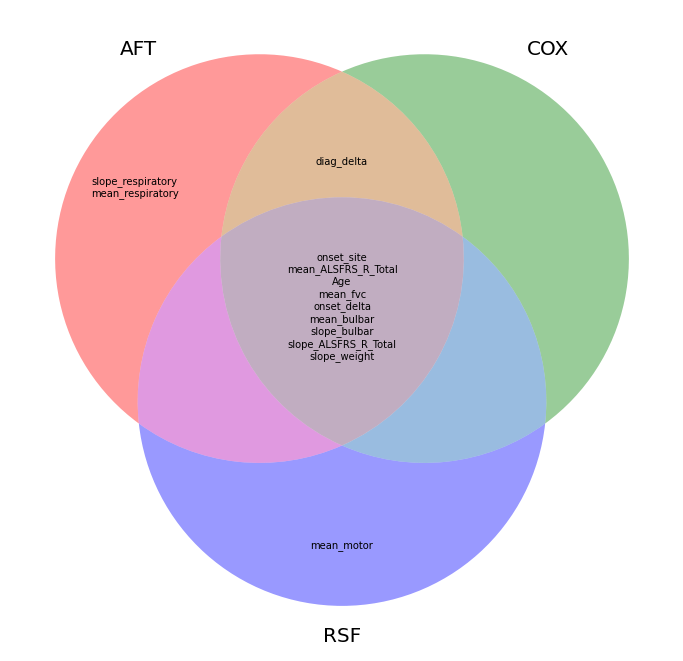

<Figure size 1800x1800 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Define 2 sets
A = set(aft_final_feature_list)
B = set(cph_final_feature_list)
C = set(rsf_final_feature_list)

# Create and instance of a venn diagram with 2 areas
plt.figure(figsize=(12,12))
diagram = venn3_unweighted([A, B, C], ("AFT", "COX", "RSF"))

# Set text content of areas
diagram.get_label_by_id("100").set_text("\n".join(A - B - C))
diagram.get_label_by_id("010").set_text("\n".join(B - A - C))
diagram.get_label_by_id("001").set_text("\n".join(C - B - A))
diagram.get_label_by_id("110").set_text("\n".join(A & B - C))
diagram.get_label_by_id("101").set_text("\n".join(A & C - B))
diagram.get_label_by_id("011").set_text("\n".join(C & B - A))
diagram.get_label_by_id("111").set_text("\n".join(A & B & C))

# Modify font sizes
for text in diagram.set_labels:
    text.set_fontsize(20)
for text in diagram.subset_labels:
    text.set_fontsize(10)

plt.figure(figsize=(25,25))
plt.show()